In [1]:
import numpy as np
import pandas as pd

In [2]:
import os
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.color import rgb2lab
from tqdm import tqdm

2025-08-16 01:39:18.319154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755308358.652606      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755308358.753700      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Load the NPZ files
X_train = np.load('/kaggle/input/cifar-2/CIFAR2-ds/cifar2_train_images.npy')
Y_train = np.load('/kaggle/input/cifar-2/CIFAR2-ds/cifar2_train_labels.npy')
X_test  = np.load('/kaggle/input/cifar-2/CIFAR2-ds/cifar2_test_images.npy')
Y_test  = np.load('/kaggle/input/cifar-2/CIFAR2-ds/cifar2_test_labels.npy')

# Ensure labels have shape (num_samples, 1), similar to cifar10.load_data()
# Y_train = Y_train.reshape(-1, 1)
# Y_test  = Y_test.reshape(-1, 1)

# Now the format matches: (x_train, y_train), (x_test, y_test)
print(X_train.shape, Y_train.shape)  # (60000, 28, 28, 1), (60000, 1)
print(X_test.shape, Y_test.shape)    # (10000, 28, 28, 1), (10000, 1)

(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


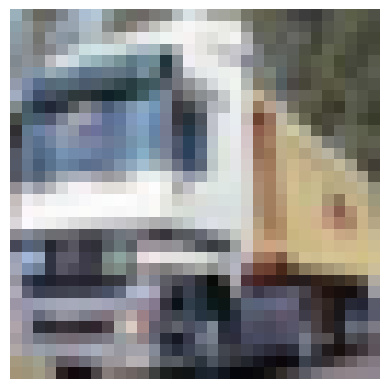

In [9]:
array_2d = X_train[1]

plt.imshow(array_2d, cmap='gray')
plt.axis('off')
plt.show()

In [10]:
Y_train[1]

1

In [11]:
np.unique(Y_train)

array([0, 1])

In [12]:
HOG_ORIENTATIONS = 9
HOG_PIXELS_PER_CELL = (8, 8)
HOG_CELLS_PER_BLOCK = (2, 2)

In [18]:
def extract_hog_features_from_array(img_rgb):
    # Convert to grayscale
    img_gray = rgb2gray(img_rgb)

    # Extract HOG features
    features = hog(
        img_gray,
        orientations=HOG_ORIENTATIONS,
        pixels_per_cell=HOG_PIXELS_PER_CELL,
        cells_per_block=HOG_CELLS_PER_BLOCK,
        block_norm='L2-Hys',
        visualize=False,
        channel_axis=None  # Because grayscale
    )

    return features

In [19]:
hog_features_train = np.array([extract_hog_features_from_array(img) for img in X_train])

In [20]:
hog_features_test = np.array([extract_hog_features_from_array(img) for img in X_test])

In [21]:
hog_features_test.shape

(10000, 324)

In [22]:
np.save("HOG_train.npy", hog_features_train)

In [23]:
np.save("HOG_test.npy", hog_features_test)

In [24]:
def color_thermometers_from_rgb(img_rgb, block_size=(3, 3)):
    """
    Extract block-wise mean RGB features from an image.
    """
    height, width, channels = img_rgb.shape
    block_height, block_width = block_size

    rgb_values = []

    for i in range(0, height, block_height):
        for j in range(0, width, block_width):
            block = img_rgb[i:i+block_height, j:j+block_width, :]
            mean_rgb = np.mean(block.reshape(-1, channels), axis=0)  # mean per channel
            rgb_values.extend(mean_rgb)  # flatten R,G,B into feature vector

    return np.array(rgb_values)

In [25]:
def process_color_thermometers_array(images, block_size=(3, 3)):
    """
    Apply RGB color thermometer extraction to a set of images.
    """
    color_features = []
    for img in tqdm(images):
        features = color_thermometers_from_rgb(img, block_size)
        color_features.append(features)
    return np.array(color_features)

In [26]:
# Extract RGB color thermometer features
train_color_3x3_features = process_color_thermometers_array(X_train, block_size=(3, 3))
test_color_3x3_features = process_color_thermometers_array(X_test, block_size=(3, 3))

train_color_4x4_features = process_color_thermometers_array(X_train, block_size=(4, 4))
test_color_4x4_features = process_color_thermometers_array(X_test, block_size=(4, 4))

# Check shapes
print("Train Color 3x3 Features Shape:", train_color_3x3_features.shape)
print("Test Color 3x3 Features Shape:", test_color_3x3_features.shape)

print("Train Color 4x4 Features Shape:", train_color_4x4_features.shape)
print("Test Color 4x4 Features Shape:", test_color_4x4_features.shape)

100%|██████████| 10000/10000 [00:09<00:00, 1013.98it/s]

Train Color 3x3 Features Shape: (50000, 363)
Test Color 3x3 Features Shape: (10000, 363)
Train Color 4x4 Features Shape: (50000, 192)
Test Color 4x4 Features Shape: (10000, 192)


In [27]:
np.save("3X3_train.npy", train_color_3x3_features)
np.save("3X3_test.npy", test_color_3x3_features)

np.save("4X4_train.npy", train_color_4x4_features)
np.save("4X4_test.npy", test_color_4x4_features)

In [28]:
Y_train

array([0, 1, 1, ..., 1, 1, 1])

In [29]:
np.save("train_labels.npy", Y_train)
np.save("test_labels.npy", Y_test)